# Visualize RNA-seq, ATAC-seq, and bimodal input

In [2]:
# import needed modules:

# general python utilities
import os
import platform
import random
import shutil
import sys
import time
import datetime
import functools
import itertools as it
import copy

# recommended Python3 version >= 3.5
print('Python version: {}'.format(platform.sys.version))

# data-science & processing tools
import numpy as np
import pandas as pd
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import h5py
import scanpy as sc
import anndata as ann


# progress bar
try:
    from tqdm.notebook import tqdm
except ImportError:
    from tqdm import tqdm_notebook as tqdm

# plotting utilities
import seaborn as sns
import matplotlib.pyplot as plt

# tensorflow
import tensorflow as tf
import tensorflow.keras as K

# required TensorFlow version >= 2.0.0
tf_version = tf.__version__
print('TensorFlow version: {}'.format(tf_version))
assert int(tf_version[0]) >= 2, "Tensorflow version must be >= 2.0"

# seed random numbers for reproducibility
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

print('\nImports Complete.')

Python version: 3.7.6 | packaged by conda-forge | (default, Jan  7 2020, 22:05:27) 
[Clang 9.0.1 ]
TensorFlow version: 2.1.0

Imports Complete.


## Load Data

In [4]:
''' Load in matrices generated after pre-processing steps '''
PATH = os.getcwd() # make sure cwd is 6_874-Multimodal-DL
OUTPUTS = os.path.join(PATH, 'Outputs')
atac_data_path = os.path.join(OUTPUTS, 'atacRaw_LowDim_svd50')
rna_data_path = os.path.join(OUTPUTS, 'rnaRaw_LowDim_pca30')
# bimodal_data_path = os.path.join(OUTPUTS, 'scAi_CellLoad')
bi_low_data_path = os.path.join(OUTPUTS, 'scAi_CellLoad')


# save as pandas dataframes
atac_df = pd.read_hdf(atac_data_path)
rna_df = pd.read_hdf(rna_data_path)
# bimodal_df = pd.read_hdf(bimodal_data_path)
bi_low_df = pd.read_hdf(bi_low_data_path)

In [5]:
# merge rna and atac together if bimodal dataset not already created
bimodal_df = pd.merge(rna_df, atac_df, on=['sample', 'treatTime'], suffixes=('_rna', '_atac'))

In [7]:
bimodal_df.head()

,sample,treatTime,0_rna,1_rna,2_rna,3_rna,4_rna,5_rna,6_rna,7_rna,...,40,41,42,43,44,45,46,47,48,49
0,sci_RNA_A_001_TCTCTCATCC,0,0.510417,5.928225,-0.037952,3.333141,4.219339,-2.630160,-0.615409,-1.955352,...,-0.219865,-0.231562,0.337380,0.989798,-0.549120,-1.325104,-0.122239,-1.658196,-0.432369,1.570464
1,sci_RNA_A_001_GACCAATGCG,0,3.000306,3.185586,-3.430007,0.491120,0.120340,1.625035,0.064617,0.429203,...,-0.870405,0.755284,-0.041358,-1.395688,1.181735,0.216738,1.692452,2.100674,-2.560527,-0.160578
2,sci_RNA_A_002_ATCTAGGTTC,0,5.106206,2.963834,-1.492047,0.171599,2.810880,1.545500,-1.419537,-0.902134,...,0.567374,-0.888025,-0.493230,0.326492,-0.125542,0.272746,0.047104,-0.223998,-0.616991,0.289083
3,sci_RNA_A_003_ACGTTGAATG,0,3.475368,5.050186,2.494665,3.177159,1.763771,4.073036,-1.079724,1.063159,...,0.995619,-1.017011,0.502295,0.181715,-0.152512,0.136581,0.448731,0.966281,-0.715115,0.232737
4,sci_RNA_A_003_CCTAAGCGGT,0,-3.759883,4.795824,-0.568844,5.767854,0.529048,0.853587,-1.837509,-1.616718,...,-0.821355,0.565135,1.437746,0.354603,-0.120906,-0.581741,-0.219004,0.254667,-0.181056,0.308072


**Observations**: 
- There are over 20,000 features, but only 3260 samples. Consider using PCA or another dimensionality reduction method before inputing into network
- This matrix is super sparse. Think about how to account for that (maybe in feature selection)
- TODO - feature selection

In [8]:
''' Get feature labels '''
# get features
atac_features = atac_df.iloc[:, 2:].columns
rna_features = rna_df.iloc[:, 2:].columns
bimodal_features = bimodal_df.iloc[:, 2:].columns
bi_low_features = bi_low_df.iloc[:, 2:].columns


# get number of features
n_atac_features = len(atac_features)
n_rna_features = len(rna_features)
n_bi_features = len(bimodal_features)
n_bi_low_features = len(bi_low_features)

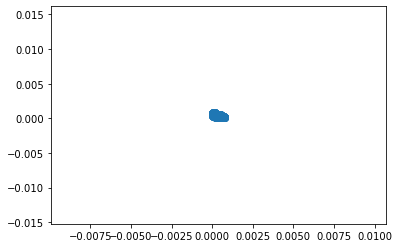

In [27]:
plt.scatter(bi_low_df['factor1'], bi_low_df['factor2']);

In [9]:
bimodal_df.head()

,sample,treatTime,0_rna,1_rna,2_rna,3_rna,4_rna,5_rna,6_rna,7_rna,...,40,41,42,43,44,45,46,47,48,49
0,sci_RNA_A_001_TCTCTCATCC,0,0.510417,5.928225,-0.037952,3.333141,4.219339,-2.630160,-0.615409,-1.955352,...,-0.219865,-0.231562,0.337380,0.989798,-0.549120,-1.325104,-0.122239,-1.658196,-0.432369,1.570464
1,sci_RNA_A_001_GACCAATGCG,0,3.000306,3.185586,-3.430007,0.491120,0.120340,1.625035,0.064617,0.429203,...,-0.870405,0.755284,-0.041358,-1.395688,1.181735,0.216738,1.692452,2.100674,-2.560527,-0.160578
2,sci_RNA_A_002_ATCTAGGTTC,0,5.106206,2.963834,-1.492047,0.171599,2.810880,1.545500,-1.419537,-0.902134,...,0.567374,-0.888025,-0.493230,0.326492,-0.125542,0.272746,0.047104,-0.223998,-0.616991,0.289083
3,sci_RNA_A_003_ACGTTGAATG,0,3.475368,5.050186,2.494665,3.177159,1.763771,4.073036,-1.079724,1.063159,...,0.995619,-1.017011,0.502295,0.181715,-0.152512,0.136581,0.448731,0.966281,-0.715115,0.232737
4,sci_RNA_A_003_CCTAAGCGGT,0,-3.759883,4.795824,-0.568844,5.767854,0.529048,0.853587,-1.837509,-1.616718,...,-0.821355,0.565135,1.437746,0.354603,-0.120906,-0.581741,-0.219004,0.254667,-0.181056,0.308072


## UMAP plots

In [10]:
''' Try plotting with UMAP (later)'''
''' Create AnnData object'''
def create_AnnData_from_df(df, obs='treatment_time', label_cutoff_ix=5):
    '''
        @params:
        Given spectra df, creates AnnData matrix
        label_cutoff_ix: columns index where spectral data begins
        
        @returns: annData object
    '''
    obs_nonspatial = pd.DataFrame(df[obs])
    var_nonspatial = pd.DataFrame(df.iloc[:,label_cutoff_ix:].columns)
    signal = df.iloc[:,label_cutoff_ix:].to_numpy()
    ann_df = ann.AnnData(X=signal)
    
    # change variable and observation names
    ann_df.obs = obs_nonspatial
    ann_df.var = var_nonspatial
    
    return ann_df

In [11]:
''' Makelabels into string to plot categorical data'''
atac_df['treatTime'] = list(map(str, atac_df['treatTime']))

rna_df['treatTime'] = list(map(str, rna_df['treatTime']))

bimodal_df['treatTime'] = list(map(str, bimodal_df['treatTime']))

bi_low_df['treatTime'] = list(map(str, bi_low_df['treatTime']))

In [12]:
''' Create AnnData objects'''
ann_atac = create_AnnData_from_df(atac_df, obs='treatTime', label_cutoff_ix=3)
ann_rna = create_AnnData_from_df(rna_df, obs='treatTime', label_cutoff_ix=3)
ann_bimodal = create_AnnData_from_df(bimodal_df, obs='treatTime', label_cutoff_ix=3)
ann_bi_low = create_AnnData_from_df(bi_low_df, obs='treatTime', label_cutoff_ix=3)

AnnData expects string indices for some functionality, but your first two indices are: Int64Index([0, 1], dtype='int64'). 
AnnData expects string indices for some functionality, but your first two indices are: RangeIndex(start=0, stop=2, step=1). 
AnnData expects string indices for some functionality, but your first two indices are: Int64Index([0, 1], dtype='int64'). 
AnnData expects string indices for some functionality, but your first two indices are: RangeIndex(start=0, stop=2, step=1). 
AnnData expects string indices for some functionality, but your first two indices are: Int64Index([0, 1], dtype='int64'). 
AnnData expects string indices for some functionality, but your first two indices are: RangeIndex(start=0, stop=2, step=1). 
AnnData expects string indices for some functionality, but your first two indices are: Int64Index([0, 1], dtype='int64'). 
AnnData expects string indices for some functionality, but your first two indices are: RangeIndex(start=0, stop=1, step=1). 


In [13]:
def UMAP(df):
    sc.tl.pca(df)
    # sc.pl.pca(df, color='day')
    # sc.pl.pca_variance_ratio(df, log=True)
    sc.pp.neighbors(df)
    sc.tl.umap(df)

In [14]:
UMAP(ann_atac)

In [15]:
UMAP(ann_rna)

In [16]:
UMAP(ann_bimodal)

In [22]:
UMAP(ann_bi_low)

/Users/tjamesso/miniconda3/envs/broad/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


ValueError: Expected 2D array, got 1D array instead:
array=[0.00066535 0.00050535 0.00045888 ... 0.00026574 0.00020431 0.00031429].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

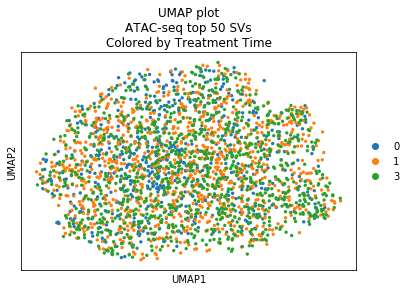

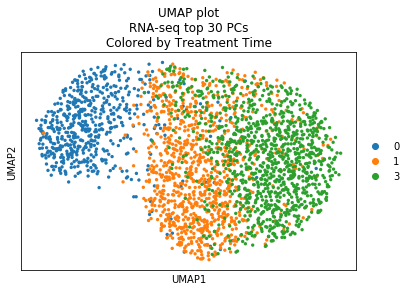

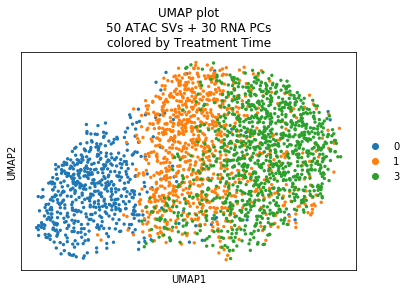

In [21]:
''' Plot UMAPs'''
sc.pl.umap(ann_atac, color=['treatTime'], 
              title=['UMAP plot\nATAC-seq top 50 SVs\nColored by Treatment Time'],)
              # palette='Purples')

sc.pl.umap(ann_rna, color=['treatTime'], 
              title=['UMAP plot\nRNA-seq top 30 PCs\nColored by Treatment Time'])
              #palette='Purples')
    
sc.pl.umap(ann_bimodal, color=['treatTime'], 
            title=['UMAP plot\n50 ATAC SVs + 30 RNA PCs\ncolored by Treatment Time'])
              #palette='Purples')
    
# sc.pl.umap(ann_bi_low, color=['treatTime'], 
#             title=['UMAP plot\nLow-D Bimodal input\ncolored Treatment Time'])
#               #palette='Purples')

In [ ]:
atac_df['treatTime'].value_counts()

In [ ]:
rna_df['treatTime'].value_counts()

In [ ]:
bimodal_df['treatTime'].value_counts()

In [ ]:
bi_low_df['treatTime'].value_counts()

##### **Observation**: These datasets are not balanced. The bimodal df has far more cells treated for 3 hours than for 0 hours

## t-SNE Plots

In [21]:
''' Get X coordinates'''
atac_np = atac_df.iloc[:,2:].to_numpy()
rna_np = rna_df.iloc[:,2:].to_numpy()
bimodal_np = bimodal_df.iloc[:,2:].to_numpy()
bi_low_np = bi_low_df.iloc[:,2:].to_numpy()

In [22]:
''' Get y coordinates'''
atac_labels = atac_df['treatTime']
rna_labels =  rna_df['treatTime']
bimodal_labels = bimodal_df['treatTime']
bi_low_labels = bimodal_df['treatTime']

In [23]:
''' Reduce dimensionality using PCA '''
a_pca = PCA(n_components=50)
atac_pca = a_pca.fit_transform(atac_np)

r_pca = PCA(n_components=50)
rna_pca = r_pca.fit_transform(rna_np)

b_pca = PCA(n_components=50)
bimodal_pca = b_pca.fit_transform(bimodal_np)

bl_pca = PCA(n_components=50)
bi_low_pca = bl_pca.fit_transform(bi_low_np)

In [24]:
''' Perform t-SNE embeddings '''
atac_embedded = TSNE(n_components=2).fit_transform(atac_pca)

rna_embedded = TSNE(n_components=2).fit_transform(rna_pca)

bimodal_embedded = TSNE(n_components=2).fit_transform(bimodal_pca)

bi_low_embedded = TSNE(n_components=2).fit_transform(bi_low_pca)

In [29]:
''' Take a look at labels'''
atac_labels[0]

'0'

In [30]:
''' Plot t-SNE plots '''
atac_0 = atac_labels == '0'
atac_1 = atac_labels == '1'
atac_3 = atac_labels == '3'

In [31]:
atac_embedded[atac_0][:,0].shape, atac_embedded[atac_1][:,0].shape, atac_embedded[atac_3][:,0].shape

((583,), (983,), (1075,))

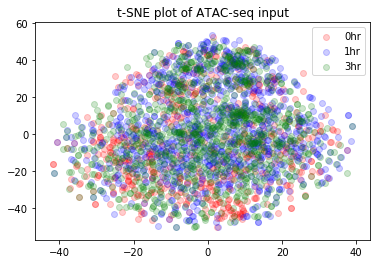

In [32]:
plt.scatter(atac_embedded[atac_0][:,0], atac_embedded[atac_0][:,1],color='red', alpha=0.2)
plt.scatter(atac_embedded[atac_1][:,0], atac_embedded[atac_1][:,1],color='blue', alpha=0.2)
plt.scatter(atac_embedded[atac_3][:,0], atac_embedded[atac_3][:,1],color='green', alpha=0.2)
plt.title('t-SNE plot of ATAC-seq input')
plt.legend(['0hr', '1hr', '3hr']);

In [33]:
''' Take a look at labels'''
rna_labels

0       0
1       0
2       0
3       0
4       0
       ..
2636    3
2637    3
2638    3
2639    3
2640    3
Name: treatTime, Length: 2641, dtype: object

In [34]:
''' Plot t-SNE plots '''
rna_0 = rna_labels == '0'
rna_1 = rna_labels == '1'
rna_3 = rna_labels == '3'

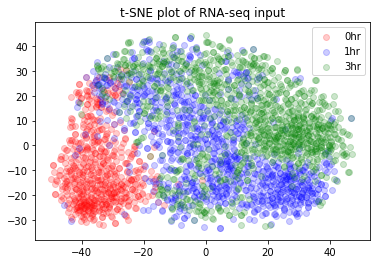

In [35]:
plt.scatter(rna_embedded[rna_0][:,0], rna_embedded[rna_0][:,1],color='red', alpha=0.2)
plt.scatter(rna_embedded[rna_1][:,0], rna_embedded[rna_1][:,1],color='blue', alpha=0.2)
plt.scatter(rna_embedded[rna_3][:,0], rna_embedded[rna_3][:,1],color='green', alpha=0.2)
plt.title('t-SNE plot of RNA-seq input');
plt.legend(['0hr', '1hr', '3hr']);

In [36]:
''' Take a look at labels'''
bimodal_labels

0       0
1       0
2       0
3       0
4       0
       ..
2636    3
2637    3
2638    3
2639    3
2640    3
Name: treatTime, Length: 2641, dtype: object

In [37]:
''' Plot t-SNE plots '''
bi_0 = bimodal_labels == '0'
bi_1 = bimodal_labels == '1'
bi_3 = bimodal_labels == '3'

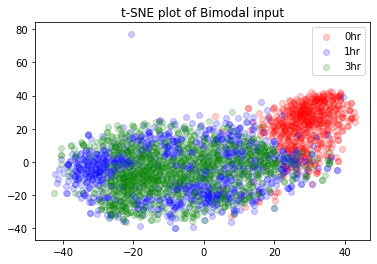

In [38]:
plt.scatter(bimodal_embedded[bi_0][:,0], bimodal_embedded[bi_0][:,1],color='red', alpha=0.2)
plt.scatter(bimodal_embedded[bi_1][:,0], bimodal_embedded[bi_1][:,1],color='blue', alpha=0.2)
plt.scatter(bimodal_embedded[bi_3][:,0], bimodal_embedded[bi_3][:,1],color='green', alpha=0.2)
plt.title('t-SNE plot of Bimodal input');
plt.legend(['0hr', '1hr', '3hr']);

In [39]:
''' Take a look at labels'''
bi_low_labels

0       0
1       0
2       0
3       0
4       0
       ..
2636    3
2637    3
2638    3
2639    3
2640    3
Name: treatTime, Length: 2641, dtype: object

In [40]:
''' Plot t-SNE plots '''
bi_low_0 = bi_low_labels == '0'
bi_low_1 = bi_low_labels == '1'
bi_low_3 = bi_low_labels == '3'

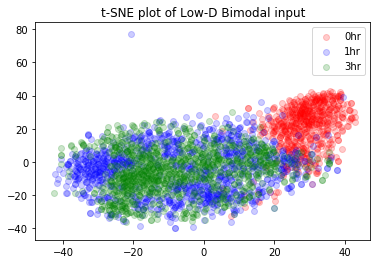

In [42]:
plt.scatter(bimodal_embedded[bi_0][:,0], bimodal_embedded[bi_0][:,1],color='red', alpha=0.2)
plt.scatter(bimodal_embedded[bi_1][:,0], bimodal_embedded[bi_1][:,1],color='blue', alpha=0.2)
plt.scatter(bimodal_embedded[bi_3][:,0], bimodal_embedded[bi_3][:,1],color='green', alpha=0.2)
plt.title('t-SNE plot of Low-D Bimodal input');
plt.legend(['0hr', '1hr', '3hr']);